In [ ]:
# default_exp datasets

In [ ]:
# hide
import blackhc.project.script
from nbdev.showdoc import *

# Datasets

> What the name says...

In [ ]:
# exports

import functools
from dataclasses import dataclass

import kornia.augmentation as K
import numpy as np
import torch
from ddu_dirty_mnist import DirtyMNIST, DistributionalAmbiguousMNIST
from sklearn.model_selection import StratifiedShuffleSplit
from torch import nn
from torch.utils import data
from torchvision import datasets, transforms

from batchbald_redux.dataset_operations import NamedDataset, get_targets
from batchbald_redux.cinic10 import CINIC10
from batchbald_redux.fast_mnist import FastFashionMNIST, FastMNIST

In [ ]:
# exports


@dataclass
class SplitDataset:
    input_size: int
    num_classes: int
    options: dict

    train: NamedDataset
    validation: NamedDataset
    test: NamedDataset

    train_augmentations: nn.Sequential
    device: str


@dataclass
class SplitDataLoader:
    input_size: int
    num_class: int
    options: dict

    train: data.DataLoader
    validation: data.DataLoader
    test: data.DataLoader

    train_augmentations: nn.Sequential

In [ ]:
# exports


def train_validation_split(*, full_train_dataset, train_labels, validation_set_size, validation_split_random_state):
    # Split off validation set
    if validation_set_size > 0:
        cv = StratifiedShuffleSplit(
            n_splits=1, test_size=validation_set_size, random_state=validation_split_random_state
        )
        for train_indices, validation_indices in cv.split(
            X=np.zeros(len(full_train_dataset)), y=np.asarray(torch.as_tensor(train_labels).cpu())
        ):
            pass
    else:
        # Always wrap the dataset in a subset so there
        train_indices = list(range(len(full_train_dataset)))
        validation_indices = []

    train_dataset = data.Subset(full_train_dataset, train_indices)
    validation_dataset = data.Subset(full_train_dataset, validation_indices)

    return train_dataset, validation_dataset

In [ ]:
# exports

CIFAR10_NORMALIZE = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
CIFAR10_BATCH_NORMALIZE = K.Normalize(
    torch.as_tensor([0.4914, 0.4822, 0.4465]), torch.as_tensor([0.2023, 0.1994, 0.2010])
)
CIFAR10_BATCH_DENORMALIZE = K.Denormalize(
    torch.as_tensor([0.4914, 0.4822, 0.4465]), torch.as_tensor([0.2023, 0.1994, 0.2010])
)

CINIC10_NORMALIZE = transforms.Normalize((0.47889522, 0.47227842, 0.43047404), (0.24205776, 0.23828046, 0.25874835))


def get_SVHN(*, root, validation_set_size, validation_split_random_state, normalize_like_cifar10, device_hint):
    input_size = 32
    num_classes = 10

    # NOTE: these are not correct mean and std for SVHN, but are commonly used
    normalize = CIFAR10_NORMALIZE if normalize_like_cifar10 else transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transform = transforms.Compose([transforms.ToTensor(), normalize])

    full_train_dataset = datasets.SVHN(root + "/SVHN", split="train", transform=transform, download=True)

    train_dataset, validation_dataset = train_validation_split(
        full_train_dataset=full_train_dataset,
        train_labels=full_train_dataset.labels,
        validation_set_size=validation_set_size,
        validation_split_random_state=validation_split_random_state,
    )

    test_dataset = datasets.SVHN(root + "/SVHN", split="test", transform=transform, download=True)
    return SplitDataset(
        input_size,
        num_classes,
        dict(
            validation_split_random_state=validation_split_random_state,
            normalize_like_cifar10=normalize_like_cifar10,
        ),
        NamedDataset(
            train_dataset, f"SVHN (Train, seed={validation_split_random_state}, {len(train_dataset)} samples)"
        ),
        NamedDataset(
            validation_dataset,
            f"SVHN (Validation, seed={validation_split_random_state}, {len(validation_dataset)} samples)",
        ),
        NamedDataset(test_dataset, "SVHN (Test)"),
        nn.Sequential(),
        "cpu",
    )


def get_CIFAR10(*, root, validation_set_size, validation_split_random_state, normalize_like_cifar10, device_hint):
    input_size = 32
    num_classes = 10

    dataset_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            CIFAR10_NORMALIZE,
        ]
    )

    train_augmentations = nn.Sequential(
        K.RandomCrop((32, 32), padding=4),
        K.RandomHorizontalFlip(),
    )

    full_train_dataset = datasets.CIFAR10(root + "/CIFAR10", train=True, transform=dataset_transform, download=True)

    train_dataset, validation_dataset = train_validation_split(
        full_train_dataset=full_train_dataset,
        train_labels=full_train_dataset.targets,
        validation_set_size=validation_set_size,
        validation_split_random_state=validation_split_random_state,
    )

    test_dataset = datasets.CIFAR10(root + "/CIFAR10", train=False, transform=dataset_transform, download=True)

    return SplitDataset(
        input_size,
        num_classes,
        dict(
            validation_split_random_state=validation_split_random_state,
            normalize_like_cifar10=True,
        ),
        NamedDataset(
            train_dataset, f"CIFAR-10 (Train, seed={validation_split_random_state}, {len(train_dataset)} samples)"
        ),
        NamedDataset(
            validation_dataset,
            f"CIFAR-10 (Validation, seed={validation_split_random_state}, {len(validation_dataset)} samples)",
        ),
        NamedDataset(test_dataset, "CIFAR-10 (Test)"),
        train_augmentations,
        "cpu",
    )


def get_CINIC10(
    *, root, validation_set_size, validation_split_random_state, normalize_like_cifar10, imagenet_only, device_hint
):
    input_size = 32
    num_classes = 10

    input_size = 32
    num_classes = 10

    # NOTE: these are not correct mean and std for SVHN, but are commonly used
    normalize = CIFAR10_NORMALIZE if normalize_like_cifar10 else CINIC10_NORMALIZE
    dataset_transform = transforms.Compose([transforms.ToTensor(), normalize])

    train_augmentations = nn.Sequential(
        K.RandomCrop((32, 32), padding=4),
        K.RandomHorizontalFlip(),
    )

    train_dataset = CINIC10(
        root, split="train", transform=dataset_transform, download=True, imagenet_only=imagenet_only
    )
    validation_dataset = CINIC10(
        root, split="valid", transform=dataset_transform, download=False, imagenet_only=imagenet_only
    )

    full_train_dataset = torch.utils.data.ConcatDataset([train_dataset, validation_dataset])

    train_dataset, validation_dataset = train_validation_split(
        full_train_dataset=full_train_dataset,
        train_labels=get_targets(full_train_dataset),
        validation_set_size=validation_set_size,
        validation_split_random_state=validation_split_random_state,
    )

    test_dataset = CINIC10(root, split="test", transform=dataset_transform, download=False, imagenet_only=imagenet_only)

    return SplitDataset(
        input_size,
        num_classes,
        dict(
            validation_split_random_state=validation_split_random_state,
            normalize_like_cifar10=True,
        ),
        NamedDataset(
            train_dataset,
            f"CINIC-10 (Train, imagenet_only={imagenet_only}, seed={validation_split_random_state}, {len(train_dataset)} samples)",
        ),
        NamedDataset(
            validation_dataset,
            f"CINIC-10 (Validation, imagenet_only={imagenet_only}, seed={validation_split_random_state}, {len(validation_dataset)} samples)",
        ),
        NamedDataset(test_dataset, "CINIC-10 (Test, imagenet_only={imagenet_only})"),
        train_augmentations,
        "cpu",
    )


def get_CIFAR100(*, root, validation_set_size, validation_split_random_state, normalize_like_cifar10, device_hint):
    input_size = 32
    num_classes = 100

    normalize = (
        CIFAR10_NORMALIZE
        if normalize_like_cifar10
        else transforms.Normalize((0.5071, 0.4866, 0.4409), (0.2673, 0.2564, 0.2762))
    )

    dataset_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            normalize,
        ]
    )

    train_augmentations = nn.Sequential(
        K.RandomCrop((32, 32), padding=4),
        K.RandomHorizontalFlip(),
    )

    full_train_dataset = datasets.CIFAR100(root + "/CIFAR100", train=True, transform=dataset_transform, download=True)

    train_dataset, validation_dataset = train_validation_split(
        full_train_dataset=full_train_dataset,
        train_labels=full_train_dataset.targets,
        validation_set_size=validation_set_size,
        validation_split_random_state=validation_split_random_state,
    )

    test_dataset = datasets.CIFAR100(root + "/CIFAR100", train=False, transform=dataset_transform, download=False)

    return SplitDataset(
        input_size,
        num_classes,
        dict(
            validation_split_random_state=validation_split_random_state,
            normalize_like_cifar10=normalize_like_cifar10,
        ),
        NamedDataset(
            train_dataset, f"CIFAR-100 (Train, seed={validation_split_random_state}, {len(train_dataset)} samples)"
        ),
        NamedDataset(
            validation_dataset,
            f"CIFAR-100 (Validation, seed={validation_split_random_state}, {len(validation_dataset)} samples)",
        ),
        NamedDataset(test_dataset, "CIFAR-100 (Test)"),
        train_augmentations,
        "cpu",
    )


def get_MNIST(*, root, validation_set_size, validation_split_random_state, normalize_like_cifar10, device_hint):
    input_size = 28
    num_classes = 10

    full_train_dataset = FastMNIST(root, train=True, download=True, device=device_hint)

    train_dataset, validation_dataset = train_validation_split(
        full_train_dataset=full_train_dataset,
        train_labels=full_train_dataset.targets,
        validation_set_size=validation_set_size,
        validation_split_random_state=validation_split_random_state,
    )

    test_dataset = FastMNIST("data", train=False, device=device_hint)

    return SplitDataset(
        input_size,
        num_classes,
        dict(
            validation_split_random_state=validation_split_random_state,
            normalize_like_cifar10=normalize_like_cifar10,
        ),
        NamedDataset(
            train_dataset, f"MNIST (Train, seed={validation_split_random_state}, {len(train_dataset)} samples)"
        ),
        NamedDataset(
            validation_dataset,
            f"MNIST (Validation, seed={validation_split_random_state}, {len(validation_dataset)} samples)",
        ),
        NamedDataset(test_dataset, "MNIST (Test)"),
        nn.Sequential(),
        device_hint,
    )


def get_DirtyMNIST(*, root, validation_set_size, validation_split_random_state, normalize_like_cifar10, device_hint):
    input_size = 28
    num_classes = 10

    full_train_dataset = DirtyMNIST(root, train=True, download=True, device=device_hint)

    train_dataset, validation_dataset = train_validation_split(
        full_train_dataset=full_train_dataset.datasets[0],
        train_labels=full_train_dataset.datasets[0].targets,
        validation_set_size=validation_set_size,
        validation_split_random_state=validation_split_random_state,
    )

    test_dataset = DirtyMNIST("data", train=False, download=True, device=device_hint)

    train_dataset = torch.utils.data.ConcatDataset([train_dataset, full_train_dataset.datasets[1]])

    return SplitDataset(
        input_size,
        num_classes,
        dict(
            validation_split_random_state=validation_split_random_state,
            normalize_like_cifar10=normalize_like_cifar10,
        ),
        NamedDataset(
            train_dataset, f"DirtyMNIST (Train, seed={validation_split_random_state}, {len(train_dataset)} samples)"
        ),
        NamedDataset(
            validation_dataset,
            f"MNIST (Validation, seed={validation_split_random_state}, {len(validation_dataset)} samples)",
        ),
        NamedDataset(test_dataset, "DirtyMNIST (Test)"),
        nn.Sequential(),
        device_hint,
    )


def get_DistributionalAmbiguousMNIST(*, root, validation_set_size, validation_split_random_state, normalize_like_cifar10, device_hint):
    input_size = 28
    num_classes = 10

    train_dataset = DistributionalAmbiguousMNIST(root, train=True, download=True, device=device_hint)

    mnist_train_dataset = FastMNIST(root, train=True, download=True, device=device_hint)
    _, validation_dataset = train_validation_split(
        full_train_dataset=mnist_train_dataset,
        train_labels=mnist_train_dataset.targets,
        validation_set_size=validation_set_size,
        validation_split_random_state=validation_split_random_state,
    )

    test_dataset = DirtyMNIST("data", train=False, download=True, device=device_hint)

    return SplitDataset(
        input_size,
        num_classes,
        dict(
            validation_split_random_state=validation_split_random_state,
            normalize_like_cifar10=normalize_like_cifar10,
        ),
        NamedDataset(
            train_dataset, f"DirtyMNIST (Train, seed={validation_split_random_state}, {len(train_dataset)} samples)"
        ),
        NamedDataset(
            validation_dataset,
            f"MNIST (Validation, seed={validation_split_random_state}, {len(validation_dataset)} samples)",
        ),
        NamedDataset(test_dataset, "DirtyMNIST (Test)"),
        nn.Sequential(),
        device_hint,
    )


def get_FashionMNIST(*, root, validation_set_size, validation_split_random_state, normalize_like_cifar10, device_hint):
    input_size = 28
    num_classes = 10

    full_train_dataset = FastFashionMNIST(root, train=True, download=True, device=device_hint)

    train_dataset, validation_dataset = train_validation_split(
        full_train_dataset=full_train_dataset,
        train_labels=full_train_dataset.targets,
        validation_set_size=validation_set_size,
        validation_split_random_state=validation_split_random_state,
    )

    test_dataset = FastFashionMNIST("data", train=False, device=device_hint)

    return SplitDataset(
        input_size,
        num_classes,
        dict(
            validation_split_random_state=validation_split_random_state,
            normalize_like_cifar10=normalize_like_cifar10,
        ),
        NamedDataset(
            train_dataset, f"FashionMNIST (Train, seed={validation_split_random_state}, {len(train_dataset)} samples)"
        ),
        NamedDataset(
            validation_dataset,
            f"FashionMNIST (Validation, seed={validation_split_random_state}, {len(validation_dataset)} samples)",
        ),
        NamedDataset(test_dataset, "FashionMNIST (Test)"),
        nn.Sequential(),
        device_hint,
    )


def get_EMNIST(*, root, validation_set_size, validation_split_random_state, normalize_like_cifar10, device_hint):
    input_size = 28
    num_classes = 47

    """
    EMNIST ByClass: 814,255 characters. 62 unbalanced classes.

    EMNIST ByMerge: 814,255 characters. 47 unbalanced classes.

    EMNIST Balanced: 131,600 characters. 47 balanced classes.

    EMNIST Letters: 145,600 characters. 26 balanced classes.

    EMNIST Digits: 280,000 characters. 10 balanced classes.

    EMNIST MNIST: 70,000 characters. 10 balanced classes.
    """

    split = "bymerge"
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    full_train_dataset = datasets.EMNIST("data", split=split, train=True, download=True,
                                    transform=transform)

    test_dataset = datasets.EMNIST("data", split=split, train=False, transform=transform)

    train_dataset, validation_dataset = train_validation_split(
        full_train_dataset=full_train_dataset,
        train_labels=full_train_dataset.targets,
        validation_set_size=validation_set_size,
        validation_split_random_state=validation_split_random_state,
    )

    return SplitDataset(
        input_size,
        num_classes,
        dict(
            validation_split_random_state=validation_split_random_state,
            normalize_like_cifar10=normalize_like_cifar10,
        ),
        NamedDataset(
            train_dataset, f"EMNIST (Train, seed={validation_split_random_state}, {len(train_dataset)} samples)"
        ),
        NamedDataset(
            validation_dataset,
            f"EMNIST (Validation, seed={validation_split_random_state}, {len(validation_dataset)} samples)",
        ),
        NamedDataset(test_dataset, "EMNIST (Test)"),
        nn.Sequential(),
        device_hint,
    )

def get_balanced_EMNIST(*, root, validation_set_size, validation_split_random_state, normalize_like_cifar10, device_hint):
    input_size = 28
    num_classes = 47

    """
    EMNIST ByClass: 814,255 characters. 62 unbalanced classes.

    EMNIST ByMerge: 814,255 characters. 47 unbalanced classes.

    EMNIST Balanced: 131,600 characters. 47 balanced classes.

    EMNIST Letters: 145,600 characters. 26 balanced classes.

    EMNIST Digits: 280,000 characters. 10 balanced classes.

    EMNIST MNIST: 70,000 characters. 10 balanced classes.
    """

    split = "balanced"
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    full_train_dataset = datasets.EMNIST("data", split=split, train=True, download=True,
                                    transform=transform)

    test_dataset = datasets.EMNIST("data", split=split, train=False, transform=transform)

    train_dataset, validation_dataset = train_validation_split(
        full_train_dataset=full_train_dataset,
        train_labels=full_train_dataset.targets,
        validation_set_size=validation_set_size,
        validation_split_random_state=validation_split_random_state,
    )

    return SplitDataset(
        input_size,
        num_classes,
        dict(
            validation_split_random_state=validation_split_random_state,
            normalize_like_cifar10=normalize_like_cifar10,
        ),
        NamedDataset(
            train_dataset, f"EMNIST (Train, seed={validation_split_random_state}, {len(train_dataset)} samples)"
        ),
        NamedDataset(
            validation_dataset,
            f"EMNIST (Validation, seed={validation_split_random_state}, {len(validation_dataset)} samples)",
        ),
        NamedDataset(test_dataset, "EMNIST (Test)"),
        nn.Sequential(),
        device_hint,
    )

In [ ]:
# exports

dataset_factories = {
    "SVHN": get_SVHN,
    "CIFAR-10": get_CIFAR10,
    "CIFAR-100": get_CIFAR100,
    "CINIC-10": functools.partial(get_CINIC10, imagenet_only=False),
    "IMAGENET-CINIC-10": functools.partial(get_CINIC10, imagenet_only=True),
    "MNIST": get_MNIST,
    "DirtyMNIST": get_DirtyMNIST,
    "DistributionalAmbiguousMNIST": get_DistributionalAmbiguousMNIST,
    "EMNIST": get_EMNIST,
    "BalancedEMNIST": get_balanced_EMNIST,
    "FashionMNIST": get_FashionMNIST,
}


def get_dataset(
    name: str,
    *,
    root=None,
    validation_set_size=0,
    validation_split_random_state=0,
    normalize_like_cifar10=False,
    device_hint=None,
) -> SplitDataset:
    root = root if root is not None else "./"
    validation_set_size = validation_set_size if validation_set_size is not None else 0
    validation_split_random_state = validation_split_random_state if validation_split_random_state is not None else 0
    normalize_like_cifar10 = normalize_like_cifar10 if normalize_like_cifar10 is not None else False

    split_dataset = dataset_factories[name](
        root=root,
        validation_set_size=validation_set_size,
        validation_split_random_state=validation_split_random_state,
        normalize_like_cifar10=normalize_like_cifar10,
        device_hint=device_hint,
    )
    return split_dataset


def get_dataloaders(split_dataset: SplitDataset, *, train_batch_size=128, eval_batch_size=512, train_shuffle=True):
    # This only works well for CIFAR-10, etc and not FastMNIST, FashionMNIST!
    kwargs = {"num_workers": 4, "pin_memory": True}

    train_loader = data.DataLoader(split_dataset.train, batch_size=train_batch_size, shuffle=train_shuffle, **kwargs)

    validation_loader = data.DataLoader(split_dataset.validation, batch_size=eval_batch_size, shuffle=False, **kwargs)
    test_loader = data.DataLoader(split_dataset.test, batch_size=eval_batch_size, shuffle=False, **kwargs)

    return SplitDataLoader(
        split_dataset.input_size,
        split_dataset.num_classes,
        split_dataset.options,
        train_loader,
        validation_loader,
        test_loader,
        split_dataset.train_augmentations,
    )


def get_dataloaders_by_name(
    name: str,
    *,
    normalize_like_cifar10,
    root=None,
    validation_set_size=None,
    validation_split_random_state=None,
    train_batch_size=128,
    eval_batch_size=512,
    train_shuffle=True,
):
    split_dataset = get_dataset(
        name,
        root=root,
        validation_set_size=validation_set_size,
        validation_split_random_state=validation_split_random_state,
        normalize_like_cifar10=normalize_like_cifar10,
    )

    split_dataloaders = get_dataloaders(
        split_dataset, train_batch_size=train_batch_size, eval_batch_size=eval_batch_size, train_shuffle=train_shuffle
    )

    return split_dataloaders

## Validate that we can load all datasets

In [ ]:
# slow

get_dataloaders_by_name("CIFAR-10", normalize_like_cifar10=True, root="data")

Files already downloaded and verified
Files already downloaded and verified


SplitDataLoader(input_size=32, num_class=10, options={'validation_split_random_state': 0, 'normalize_like_cifar10': True}, train=<torch.utils.data.dataloader.DataLoader object at 0x7fcfa1bbe6d0>, validation=<torch.utils.data.dataloader.DataLoader object at 0x7fcfa1bbe8e0>, test=<torch.utils.data.dataloader.DataLoader object at 0x7fcfa1bbe700>, train_augmentations=Sequential(
  (0): RandomCrop(crop_size=(32, 32), padding=4, fill=0, pad_if_needed=False, padding_mode=constant, resample=BILINEAR, p=1.0, p_batch=1.0, same_on_batch=False, return_transform=False)
  (1): RandomHorizontalFlip(p=0.5, p_batch=1.0, same_on_batch=False, return_transform=None)
))

In [ ]:
# slow

get_dataloaders_by_name("CIFAR-100", normalize_like_cifar10=True, root="data")

Files already downloaded and verified


SplitDataLoader(input_size=32, num_class=100, options={'validation_split_random_state': 0, 'normalize_like_cifar10': True}, train=<torch.utils.data.dataloader.DataLoader object at 0x7fcfd22b83d0>, validation=<torch.utils.data.dataloader.DataLoader object at 0x7fcfd22b88e0>, test=<torch.utils.data.dataloader.DataLoader object at 0x7fcfd22b8a90>, train_augmentations=Sequential(
  (0): RandomCrop(crop_size=(32, 32), padding=4, fill=0, pad_if_needed=False, padding_mode=constant, resample=BILINEAR, p=1.0, p_batch=1.0, same_on_batch=False, return_transform=False)
  (1): RandomHorizontalFlip(p=0.5, p_batch=1.0, same_on_batch=False, return_transform=None)
))

In [ ]:
# slow

get_dataloaders_by_name("SVHN", normalize_like_cifar10=True, root="data")

Using downloaded and verified file: data/SVHN/train_32x32.mat
Using downloaded and verified file: data/SVHN/test_32x32.mat


SplitDataLoader(input_size=32, num_class=10, options={'validation_split_random_state': 0, 'normalize_like_cifar10': True}, train=<torch.utils.data.dataloader.DataLoader object at 0x7fcfc8d9b7c0>, validation=<torch.utils.data.dataloader.DataLoader object at 0x7fcfc8da5760>, test=<torch.utils.data.dataloader.DataLoader object at 0x7fcfc8da5850>, train_augmentations=Sequential())

In [ ]:
# slow

get_dataloaders_by_name("CINIC-10", normalize_like_cifar10=True, root="data")

Files already downloaded and verified


SplitDataLoader(input_size=32, num_class=10, options={'validation_split_random_state': 0, 'normalize_like_cifar10': True}, train=<torch.utils.data.dataloader.DataLoader object at 0x7fd0e467d4c0>, validation=<torch.utils.data.dataloader.DataLoader object at 0x7fcfa83250a0>, test=<torch.utils.data.dataloader.DataLoader object at 0x7fcfa8325190>, train_augmentations=Sequential(
  (0): RandomCrop(crop_size=(32, 32), padding=4, fill=0, pad_if_needed=False, padding_mode=constant, resample=BILINEAR, p=1.0, p_batch=1.0, same_on_batch=False, return_transform=False)
  (1): RandomHorizontalFlip(p=0.5, p_batch=1.0, same_on_batch=False, return_transform=None)
))

In [ ]:
# slow

get_dataloaders_by_name("EMNIST", normalize_like_cifar10=False, root="data")

SplitDataLoader(input_size=28, num_class=47, options={'validation_split_random_state': 0, 'normalize_like_cifar10': False}, train=<torch.utils.data.dataloader.DataLoader object at 0x7fcfa8325340>, validation=<torch.utils.data.dataloader.DataLoader object at 0x7fcfa8325ac0>, test=<torch.utils.data.dataloader.DataLoader object at 0x7fcfa8325b80>, train_augmentations=Sequential())

In [ ]:
# slow

get_dataloaders_by_name("MNIST", normalize_like_cifar10=False, root="data")

SplitDataLoader(input_size=28, num_class=10, options={'validation_split_random_state': 0, 'normalize_like_cifar10': False}, train=<torch.utils.data.dataloader.DataLoader object at 0x7fcfa8325ca0>, validation=<torch.utils.data.dataloader.DataLoader object at 0x7fd0f428d820>, test=<torch.utils.data.dataloader.DataLoader object at 0x7fcfa26310a0>, train_augmentations=Sequential())

In [ ]:
# slow

get_dataloaders_by_name("DirtyMNIST", normalize_like_cifar10=False, root="data")

  0%|          | 0/37632824 [00:00<?, ?it/s]

  0%|          | 0/960760 [00:00<?, ?it/s]


Done!


SplitDataLoader(input_size=28, num_class=10, options={'validation_split_random_state': 0, 'normalize_like_cifar10': False}, train=<torch.utils.data.dataloader.DataLoader object at 0x7fcfa2631910>, validation=<torch.utils.data.dataloader.DataLoader object at 0x7fcfa1bcf3a0>, test=<torch.utils.data.dataloader.DataLoader object at 0x7fcfa1bcf490>, train_augmentations=Sequential())

In [ ]:
# slow

get_dataloaders_by_name("DistributionalAmbiguousMNIST", normalize_like_cifar10=False, root="data")

  0%|          | 0/37632824 [00:00<?, ?it/s]

  0%|          | 0/480760 [00:00<?, ?it/s]


Done!


SplitDataLoader(input_size=28, num_class=10, options={'validation_split_random_state': 0, 'normalize_like_cifar10': False}, train=<torch.utils.data.dataloader.DataLoader object at 0x7fcfa1bbeb50>, validation=<torch.utils.data.dataloader.DataLoader object at 0x7fcfa1b878b0>, test=<torch.utils.data.dataloader.DataLoader object at 0x7fcfa1b874c0>, train_augmentations=Sequential())

## Validate that we can create a validation split

In [ ]:
# slow

get_dataset("CIFAR-10", normalize_like_cifar10=True, root="data", validation_set_size=5000)

Files already downloaded and verified
Files already downloaded and verified


SplitDataset(input_size=32, num_classes=10, options={'validation_split_random_state': 0, 'normalize_like_cifar10': True}, train='CIFAR-10 (Train, seed=0, 45000 samples)', validation='CIFAR-10 (Validation, seed=0, 5000 samples)', test='CIFAR-10 (Test)', train_augmentations=Sequential(
  (0): RandomCrop(crop_size=(32, 32), padding=4, fill=0, pad_if_needed=False, padding_mode=constant, resample=BILINEAR, p=1.0, p_batch=1.0, same_on_batch=False, return_transform=False)
  (1): RandomHorizontalFlip(p=0.5, p_batch=1.0, same_on_batch=False, return_transform=None)
))

In [ ]:
# slow

get_dataset("MNIST", normalize_like_cifar10=True, root="data", validation_set_size=5000)

SplitDataset(input_size=28, num_classes=10, options={'validation_split_random_state': 0, 'normalize_like_cifar10': True}, train='MNIST (Train, seed=0, 55000 samples)', validation='MNIST (Validation, seed=0, 5000 samples)', test='MNIST (Test)', train_augmentations=Sequential())

In [ ]:
# slow

get_dataset("DirtyMNIST", normalize_like_cifar10=True, root="data", validation_set_size=5000)

/home/blackhc/anaconda3/envs/active_learning/lib/python3.8/site-packages/sklearn/utils/__init__.py:1102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/home/blackhc/anaconda3/envs/active_learning/lib/python3.8/site-packages/sklearn/utils/__init__.py:1102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the pre

SplitDataset(input_size=28, num_classes=10, options={'validation_split_random_state': 0, 'normalize_like_cifar10': True}, train='DirtyMNIST (Train, seed=0, 115000 samples)', validation='MNIST (Validation, seed=0, 5000 samples)', test='DirtyMNIST (Test)', train_augmentations=Sequential(), device=None)

In [ ]:
# slow

get_dataset("DistributionalAmbiguousMNIST", normalize_like_cifar10=True, root="data", validation_set_size=5000)

/home/blackhc/anaconda3/envs/active_learning/lib/python3.8/site-packages/sklearn/utils/__init__.py:1102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/home/blackhc/anaconda3/envs/active_learning/lib/python3.8/site-packages/sklearn/utils/__init__.py:1102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the pre

SplitDataset(input_size=28, num_classes=10, options={'validation_split_random_state': 0, 'normalize_like_cifar10': True}, train='DirtyMNIST (Train, seed=0, 6000 samples)', validation='MNIST (Validation, seed=0, 5000 samples)', test='DirtyMNIST (Test)', train_augmentations=Sequential(), device=None)

In [ ]:
# slow

get_dataset("IMAGENET-CINIC-10", normalize_like_cifar10=True, root="data", validation_set_size=5000)

Files already downloaded and verified
Files already downloaded and verified


/home/blackhc/anaconda3/envs/active_learning/lib/python3.8/site-packages/sklearn/utils/__init__.py:1102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/home/blackhc/anaconda3/envs/active_learning/lib/python3.8/site-packages/sklearn/utils/__init__.py:1102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the pre

Files already downloaded and verified


SplitDataset(input_size=32, num_classes=10, options={'validation_split_random_state': 0, 'normalize_like_cifar10': True}, train='CINIC-10 (Train, imagenet_only=True, seed=0, 135000 samples)', validation='CINIC-10 (Validation, imagenet_only=True, seed=0, 5000 samples)', test='CINIC-10 (Test, imagenet_only={imagenet_only})', train_augmentations=Sequential(
  (0): RandomCrop(crop_size=(32, 32), padding=4, fill=0, pad_if_needed=False, padding_mode=constant, resample=BILINEAR, p=1.0, p_batch=1.0, same_on_batch=False, return_transform=False)
  (1): RandomHorizontalFlip(p=0.5, p_batch=1.0, same_on_batch=False, return_transform=None)
), device='cpu')

In [ ]:
# slow

get_dataset("EMNIST", normalize_like_cifar10=False, root="data", validation_set_size=5000)

/home/blackhc/anaconda3/envs/active_learning/lib/python3.8/site-packages/sklearn/utils/__init__.py:1102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/home/blackhc/anaconda3/envs/active_learning/lib/python3.8/site-packages/sklearn/utils/__init__.py:1102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the pre

SplitDataset(input_size=28, num_classes=47, options={'validation_split_random_state': 0, 'normalize_like_cifar10': False}, train='EMNIST (Train, seed=0, 692932 samples)', validation='EMNIST (Validation, seed=0, 5000 samples)', test='EMNIST (Test)', train_augmentations=Sequential(), device=None)

## Validate Kornia augmentations

In [ ]:
# slow

import kornia
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

split_dataloaders = get_dataloaders_by_name("CIFAR-10", normalize_like_cifar10=True, root="data")

torch.Size([128, 3, 32, 32])


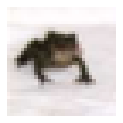

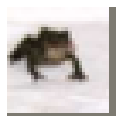

In [ ]:
# slow

for image_batch, labels in split_dataloaders.train:
    break

print(image_batch.shape)

image_rgb: np.ndarray = kornia.tensor_to_image(CIFAR10_BATCH_DENORMALIZE(image_batch))
fig, axs = plt.subplots(1, 1, figsize=(2, 2))

axs.axis("off")
axs.imshow(image_rgb[0])
plt.show()

image_rgb: np.ndarray = kornia.tensor_to_image(
    CIFAR10_BATCH_DENORMALIZE(split_dataloaders.train_augmentations(image_batch))
)

fig, axs = plt.subplots(1, 1, figsize=(2, 2))
axs.axis("off")
axs.imshow(image_rgb[0])
plt.show()